# Example kNN regression and classification

**Author**: Jyri Kivinen (jyri.kivinen@lapinamk.fi)

**Version**: 8 September, 2023

**Credits**: The notebook uses some features of, draws inspiration from, the code presented in https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html (page generated 8 September, 2023) and having the code stated licence:

```
    # Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
    #         Fabian Pedregosa <fabian.pedregosa@inria.fr>`
    #
    # License: BSD 3 clause (C) INRIA
```

# Code imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import sys
sys.path.insert(0, '../../code')
from nearest_neighbors import *

# A basic regression example

In [2]:
# helper functions for creating clean and noisy observations
def create_noiseless_process_output(x, process_name='cosine'):
    if process_name == 'cosine':
        return np.cos(x)
    elif process_name == 'logistic_sigmoid':
        return 1./(1+np.exp(-x))

def add_noise(y, noise_level, process_name='uniform'):
    if process_name == 'uniform':
        return y+noise_level*(0.5-np.random.rand(y.size))
    elif process_name == 'gaussian':
        return y+noise_level*(np.random.randn(y.size))

def create_process_output(x, noise_level, noiseless_process_name='cosine', noise_process_name='uniform'):
    y_noiseless = create_noiseless_process_output(x, noiseless_process_name)
    y_noisy = add_noise(y_noiseless, noise_level, noise_process_name)
    return y_noiseless, y_noisy

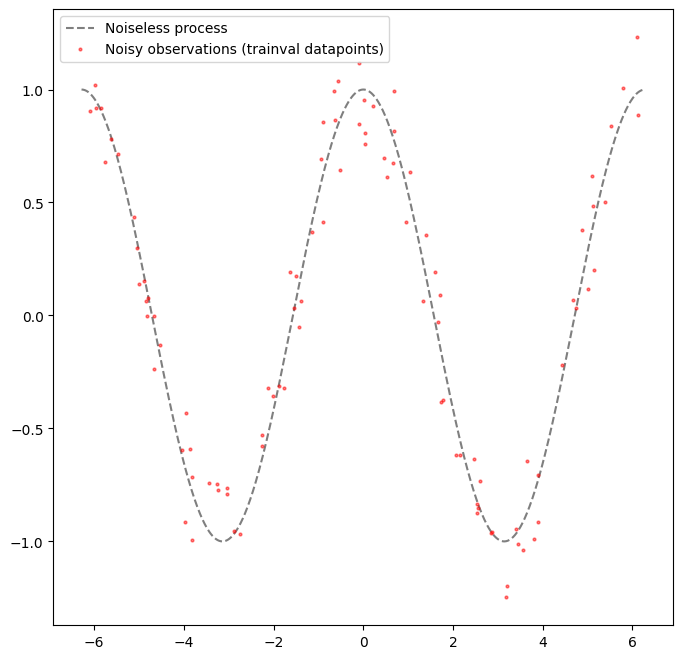

In [3]:
# speficications 
n_trainval_datapoints = 100
n_test_datapoints = 500
noise_level = 0.5
x_min = -2*np.pi
x_max = 2*np.pi
clean_data_process = 'cosine'
noise_process = 'uniform'
random_number_generator_seed = 42 

# set random number generator seed
np.random.seed(random_number_generator_seed)

# create feature values  
X = x_min+(x_max-x_min)*np.random.rand(n_trainval_datapoints+n_test_datapoints, 1)
random_indices = np.random.permutation(n_trainval_datapoints+n_test_datapoints)
X_trainval = np.sort(X[random_indices[0: n_trainval_datapoints], :].copy(), axis=0)
X_test = np.sort(X[random_indices[n_trainval_datapoints:], :].copy(), axis=0)

# create clean and noisy observations from the feature values
y_trainval_noiseless, y_trainval = create_process_output(X_trainval.ravel(), noise_level, clean_data_process, noise_process)
y_test_noiseless, y_test = create_process_output(X_test.ravel(), noise_level, clean_data_process, noise_process)

# plot data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 8])
ax.plot(np.linspace(x_min, x_max, 1000), create_noiseless_process_output(np.linspace(x_min, x_max, 1000).ravel(), clean_data_process), 
        'k--', label='Noiseless process', alpha=0.5, markersize=2)
ax.plot(X_trainval, y_trainval, 'ro', label='Noisy observations (trainval datapoints)', alpha=0.5, markersize=2)
ax.legend();

## Nearest neighbor code

In [4]:
!pygmentize ../../code/nearest_neighbors.py 

import numpy as np
from sklearn.metrics import classification_report, r2_score


class NearestNeighborClassifier:
    """
    A basic k-NN classifier
    """

    def __init__(self, name='nearest_neighbor_classifier'):
        self.name = name

    @staticmethod
    def calculate_pairwise_datapoint_distances(x_a, x_b):
        return np.sqrt(np.sum((x_b-np.reshape(x_a, (1, x_b.shape[1])))**2, axis=1))

    @staticmethod
    def calculate_neighbor_indices(pairwise_distances, n_neighbors):
        return np.argsort(pairwise_distances)[0: n_neighbors]

    @staticmethod
    def calculate_predicted_class(neighbor_indices, y):
        classes, class_counts = np.unique(y[neighbor_indices], return_counts=True)
        return classes[np.argmax(class_counts)]

    def predict(self, x, y, x_new, n_neighbors):
        n_new = x_new.shape[0]
        predicted_classes = np.empty((n_new, ), dtype=int)
        for ii in np.arange(n_new):
            pairwise_distances = self.calculate_pairwise_datapo

## Selecting a value for k 

In [5]:
# instantiate model 
kNN = NearestNeighborRegressor()

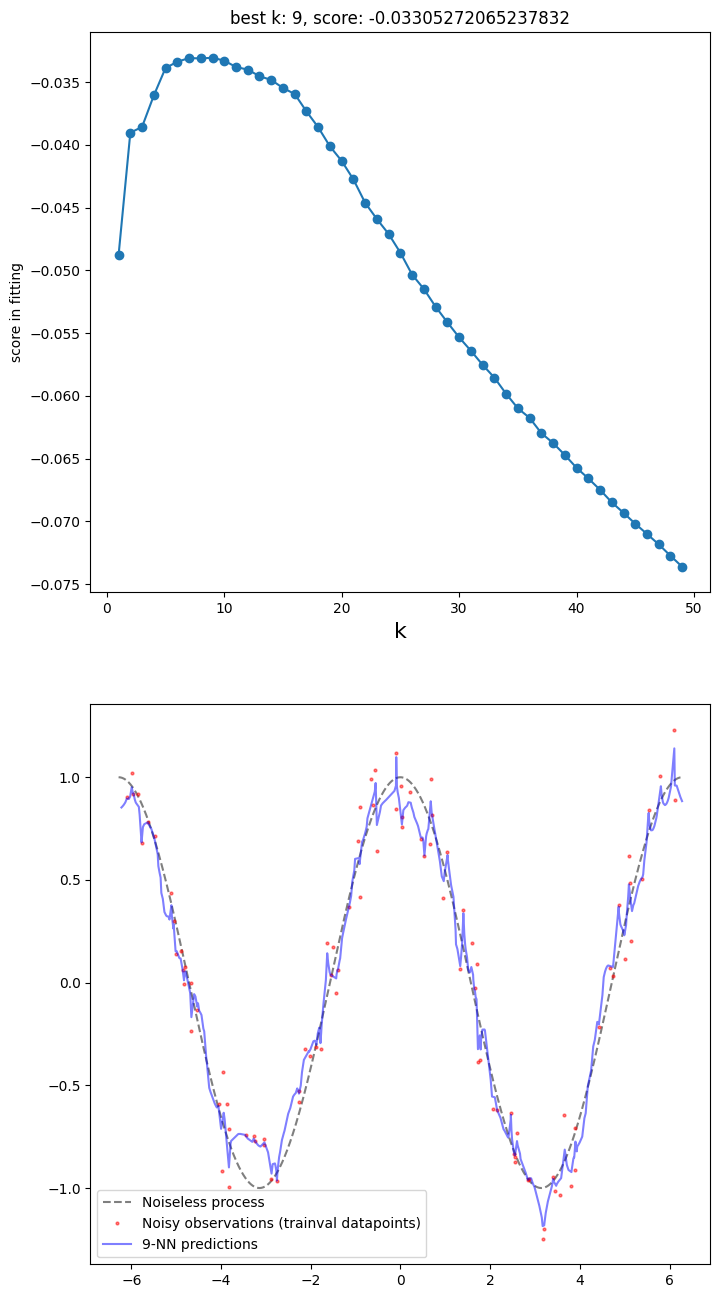

In [6]:
# leave-one-out cross-validation to choose k
n_neighbors_options = np.arange(1, 50)
distance_weighting = True
scores = np.empty(n_neighbors_options.shape)
for ii, n_neighbors in enumerate(n_neighbors_options):
    score = 0.
    for jj in np.arange(X_trainval.shape[0]):
        train_indices = (np.arange(X_trainval.shape[0]) != jj)
        val_indices = ~train_indices
        val_prediction = kNN.predict(X_trainval[train_indices, :], y_trainval[train_indices],
                                     X_trainval[val_indices, :], n_neighbors, distance_weighting)
        score -= (y_trainval[val_indices]-val_prediction)[0]**2    
    scores[ii] = score/(jj+1)
y_test_predicted = kNN.predict(X_trainval, y_trainval, X_test, n_neighbors_options[np.argmax(scores)], distance_weighting)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=[8, 16])
ax1.plot(n_neighbors_options, scores, 'o-')
ax1.set_xlabel('k', fontsize=16)
ax1.set_ylabel('score in fitting')
ax1.set_title(f'best k: {n_neighbors_options[np.argmax(scores)]}, score: {np.max(scores)}')
ax2.plot(np.linspace(x_min, x_max, 1000), create_noiseless_process_output(np.linspace(x_min, x_max, 1000).ravel(), clean_data_process), 
        'k--', label='Noiseless process', alpha=0.5, markersize=2)
ax2.plot(X_trainval, y_trainval, 'ro', label='Noisy observations (trainval datapoints)', alpha=0.5, markersize=2)
ax2.plot(X_test, y_test_predicted, 'b-', label=f'{n_neighbors_options[np.argmax(scores)]}-NN predictions', alpha=0.5, markersize=2)
ax2.legend();

## Coding: creating a new class that extends the base class with fitting of k

In [7]:
class MyNearestNeighborRegressor(NearestNeighborRegressor):
    
    def __init__(self, name='my_nearest_neighbor_regressor'):
        super().__init__()
        self.name = name
        self.k = None
        self.distance_weighting = None
        
    def my_score(self, x_new, y_new):
        return super().score(self.x, self.y, x_new, y_new, self.k, self.distance_weighting)	

    def my_fit(self, x, y, n_neighbors_options, distance_weighting=True, n_folds_in_cv=None):
        # memorize training data
        self.x = x
        self.y = y
        self.distance_weighting = distance_weighting
        # choose and store k 
        scores = np.empty(n_neighbors_options.shape)
        if n_folds_in_cv is None:  # leave-one-out 
            for ii, n_neighbors in enumerate(n_neighbors_options):
                score = 0.
                for jj in np.arange(x.shape[0]):
                    train_indices = (np.arange(x.shape[0]) != jj)
                    val_indices = ~train_indices
                    val_prediction = super().predict(x[train_indices, :], y[train_indices], x[val_indices, :], 
                                                     n_neighbors, distance_weighting)
                    score -= (y[val_indices]-val_prediction)[0]**2    
                scores[ii] = score/(jj+1)
        else:  # (stratified) cross-validation
            kf = KFold(n_splits=n_folds_in_cv)
            kf.get_n_splits(x, y)
            for ii, n_neighbors in enumerate(n_neighbors_options):
                score = 0.
                for jj, (train_indices, val_indices) in enumerate(kf.split(x, y)):
                    score += super().score(x[train_indices, :], y[train_indices], x[val_indices, :], y[val_indices], 
                                           n_neighbors, distance_weighting)    
                scores[ii] = score/(jj+1)
        self.k = n_neighbors_options[np.argmax(scores)]
        # return stats
        return scores

    def my_predict(self, x_new):
        return super().predict(self.x, self.y, x_new, self.k, self.distance_weighting)

## Experimentation with the new code 

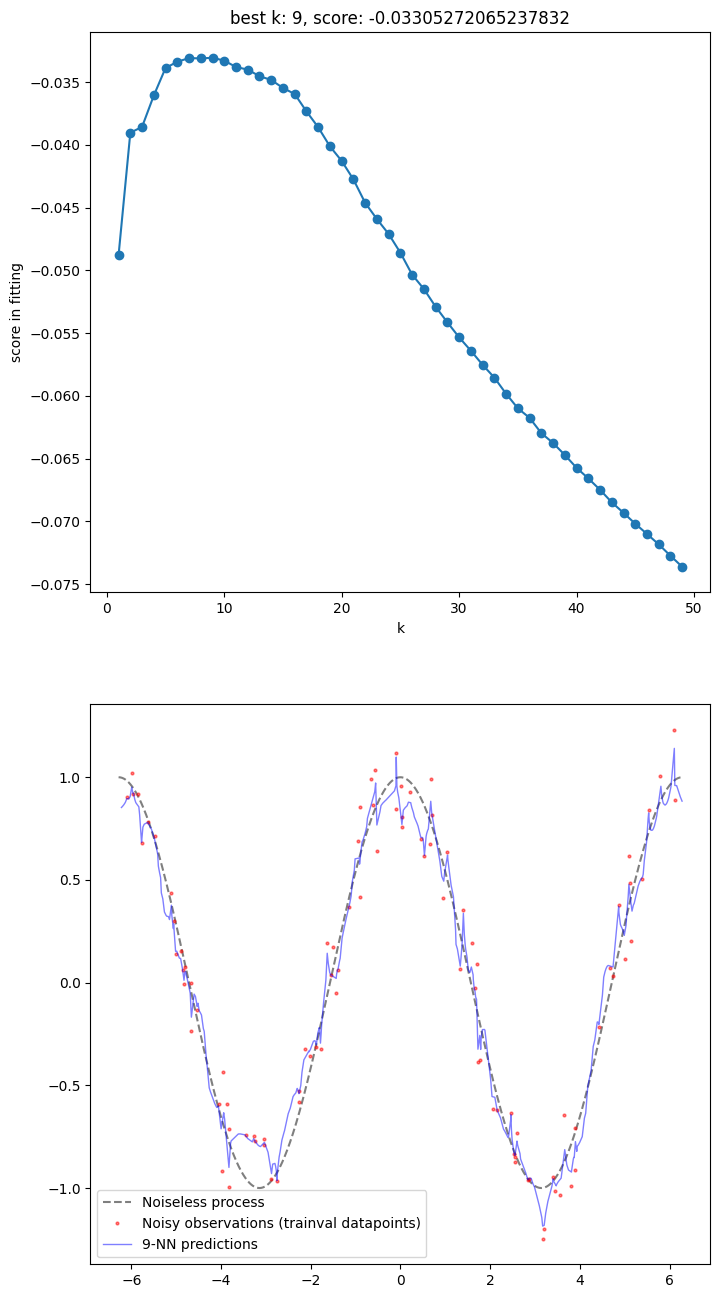

In [8]:
# create model instance
my_kNN = MyNearestNeighborRegressor()

# fit model and assess performance
scores = my_kNN.my_fit(X_trainval, y_trainval, n_neighbors_options, True, None) 

# plot fitting and prediction results
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=[8, 16])
ax1.plot(n_neighbors_options, scores, 'o-')
ax1.set_xlabel('k')
ax1.set_ylabel('score in fitting')
ax1.set_title(f'best k: {my_kNN.k}, score: {np.max(scores)}')
ax2.plot(np.linspace(x_min, x_max, 1000), create_noiseless_process_output(np.linspace(x_min, x_max, 1000).ravel(), clean_data_process), 
        'k--', label='Noiseless process', alpha=0.5, markersize=2)
ax2.plot(X_trainval, y_trainval, 'ro', label='Noisy observations (trainval datapoints)', alpha=0.5, markersize=2)
ax2.plot(X_test, my_kNN.my_predict(X_test), 'b-', label=f'{my_kNN.k}-NN predictions', alpha=0.5, markersize=2, linewidth=1)
ax2.legend();

# Classification

## Coding: creating a new class that extends the base class with fitting of k (similar to as done in the regression above)

In [9]:
class MyNearestNeighborClassifier(NearestNeighborClassifier):
    
    def __init__(self, name='my_nearest_neighbor_classifier'):
        super().__init__()
        self.name = name
        self.k = None
        
    def my_score(self, x_new, y_new):
        return super().score(self.x, self.y, x_new, y_new, self.k)	

    def my_fit(self, x, y, n_neighbors_options, n_folds_in_cv=None, fit_criteria='accuracy'):
        # memorize training data
        self.x = x
        self.y = y
        # choose and store k
        scores = np.empty(n_neighbors_options.shape)
        if n_folds_in_cv is None:  # leave-one-out
            for ii, n_neighbors in enumerate(n_neighbors_options):
                score = 0.
                for jj in np.arange(x.shape[0]):
                    train_indices = (np.arange(x.shape[0]) != jj)
                    val_indices = ~train_indices
                    val_prediction = super().predict(x[train_indices, :], y[train_indices], x[val_indices, :], n_neighbors)
                    score -= (y[val_indices]-val_prediction)[0]**2    
                scores[ii] = score/(jj+1)
        else:  # (stratified) cross-validation
            skf = StratifiedKFold(n_splits=n_folds_in_cv)
            skf.get_n_splits(x, y)
            for ii, n_neighbors in enumerate(n_neighbors_options):
                score = 0.
                for jj, (train_indices, val_indices) in enumerate(skf.split(x, y)):
                    score += super().score(x[train_indices, :], y[train_indices], x[val_indices, :], y[val_indices], n_neighbors)[fit_criteria]    
                scores[ii] = score/(jj+1)
        self.k = n_neighbors_options[np.argmax(scores)]
        # return stats
        return scores

    def my_predict(self, x_new):
        return super().predict(self.x, self.y, x_new, self.k)

## Data
Utilize the above data, so that the datapoints serve as features. 

In [10]:
# a helper function to create labels
def create_labels(xy, clean_data_process_name):
    if clean_data_process_name == 'cosine':
        return np.logical_and(xy[:, 1]>=-0.5, xy[:, 1]<=0.5).astype(int) 
    elif clean_data_process_name == 'logistic_sigmoid':
        return (xy[:, 1]>=0.5, xy[:, 1]).astype(int) 

In [11]:
X_trainval = np.concatenate((X_trainval, y_trainval[:, np.newaxis]), axis=1)
X_test = np.concatenate((X_test, y_test[:, np.newaxis]), axis=1)
y_trainval = create_labels(X_trainval, clean_data_process)
y_test = create_labels(X_test, clean_data_process)

## Experiments

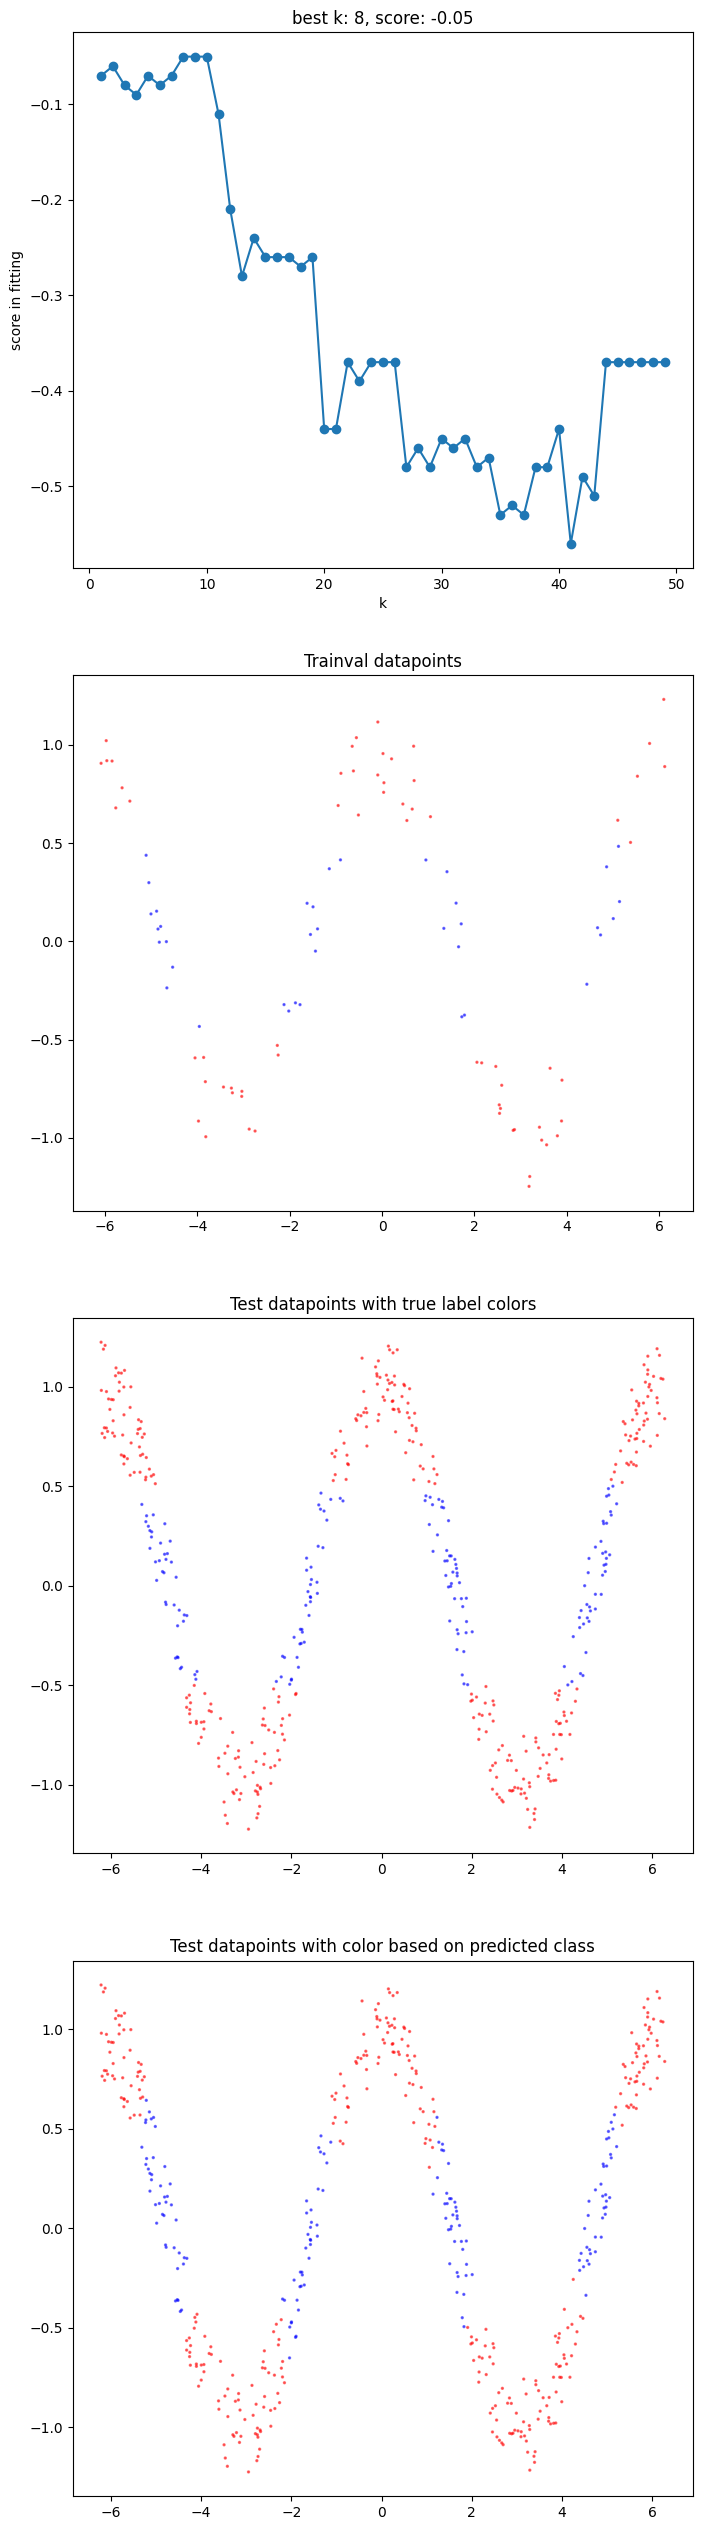

In [12]:
# create model instance
my_kNN = MyNearestNeighborClassifier()

# fit model and assess performance
scores = my_kNN.my_fit(X_trainval, y_trainval, n_neighbors_options) 

# plot fitting and prediction results
class_colors = np.array([[1., 0., 0.], [0., 0., 1.]])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=[8, 32])
ax1.plot(n_neighbors_options, scores, 'o-')
ax1.set_xlabel('k')
ax1.set_ylabel('score in fitting')
ax1.set_title(f'best k: {my_kNN.k}, score: {np.max(scores)}')
ax2.scatter(X_trainval[:, 0], X_trainval[:, 1], c=class_colors[y_trainval, :], alpha=0.5, s=2)
ax2.set_title('Trainval datapoints')
ax3.scatter(X_test[:, 0], X_test[:, 1], c=class_colors[y_test, :], alpha=0.5, s=2)
ax3.set_title('Test datapoints with true label colors')
ax4.scatter(X_test[:, 0], X_test[:, 1], c=class_colors[my_kNN.my_predict(X_test), :], alpha=0.5, s=2, label=f'{my_kNN.k}-NN predictions')
ax4.set_title('Test datapoints with color based on predicted class');